Notebook prepared by Henrique Lopes Cardoso (hlc@fe.up.pt).

# REGULARIZATION AND SGD

Regularization is a technique that allows us to avoid overfitting by penalizing excessive feature weights. Several classifiers, such as [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html),  include the option for choosing which regularization term to use.

In this notebook we'll explore the usage of different regularization terms. For that, we'll use a restaurant reviews classification task.

In [1]:
# Loading the data

import pandas as pd

# Importing the dataset
dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)

print(dataset['Liked'].value_counts())
dataset.head()

1    500
0    500
Name: Liked, dtype: int64


,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [2]:
# Cleaning the text

import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

corpus = []
ps = PorterStemmer()
for i in range(0,1000):
    # get review and remove non alpha chars
    review = re.sub('[^a-zA-Z]', ' ', dataset['Review'][i])
    # to lower-case and tokenize
    review = review.lower().split()
    # stemming and stop word removal
    review = ' '.join([ps.stem(w) for w in review if not w in set(stopwords.words('english'))])
    corpus.append(review)

In [3]:
# Creating a bag-of-words model

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features = 1500)
X = vectorizer.fit_transform(corpus).toarray()
y = dataset['Liked']

print(X.shape, y.shape)

(1000, 1500) (1000,)


In [4]:
# Splitting the dataset into training and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(y_train.value_counts())
print(y_test.value_counts())

(800, 1500) (800,)
(200, 1500) (200,)
1    400
0    400
Name: Liked, dtype: int64
0    100
1    100
Name: Liked, dtype: int64


## Logistic Regression

Scikit-learn's [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) includes both L1 and L2 regularizations. L2 is the default.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

clf = LogisticRegression(penalty='l2') # l2 regularization is the default
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[83 17]
 [22 78]]


Print the feature weights that we've obtained.

In [10]:
# your code here
clf.coef_

array([[ 0.41686797,  0.17697687,  0.        , ..., -0.20321363,
         0.64383437, -0.61415454]])

How many features are actually being used? (I.e., how many non-zero weights are there?)

In [16]:
# your code here
c = 0
for f in clf.coef_[0]:
    if f != 0:
        c += 1
print("Number of non-zero values:", c)

Number of non-zero values: 1311


L1 regularization typically obtains sparser weight vectors. Try using L1 regularization (check the documentation for additional changes you might need). How many non-zero weights do you have now?

In [18]:
# your code here
clf = LogisticRegression(solver='liblinear', penalty='l1')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
c = 0
for f in clf.coef_[0]:
    if f != 0:
        c += 1
print("Number of non-zero values:", c)

Number of non-zero values: 149


You can also try using a mix of L1 and L2 (check the documentation for how to do it).

In [21]:
# your code here
# your code here
clf = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
c = 0
for f in clf.coef_[0]:
    if f != 0:
        c += 1
print("Number of non-zero values:", c)

Number of non-zero values: 380


## SVM

Scikit-learn's [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) also includes both L1 and L2 regularizations. L2 is the default.

In [22]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

clf = LinearSVC(penalty='l2') # l2 regularization is the default

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[82 18]
 [20 80]]


How many features are actually being used? (I.e., how many non-zero weights are there?)

In [23]:
# your code here
c = 0
for f in clf.coef_[0]:
    if f != 0:
        c += 1
print("Number of non-zero values:", c)

Number of non-zero values: 1087


Try using L1 regularization (check the documentation for additional changes you might need). How many non-zero weights do you have now?

In [25]:
# your code here
clf = LinearSVC(penalty='l1', dual=False) # l2 regularization is the default

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
c = 0
for f in clf.coef_[0]:
    if f != 0:
        c += 1
print("Number of non-zero values:", c)

Number of non-zero values: 423


## SGD Classifier

Scikit-learn's [SGD Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) implements regularized linear models (such as SVM and Logistic Regression) with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing learning rate.

Several loss functions can be used, namely *hinge loss* (which corresponds to SVM) and *log loss* (which corresponds to Logistic Regression). And as before, you can use L1 and/or L2 regularization.

The *max_iter* parameter allows you to set the maximum number of epochs, where an epoch corresponds to going through the whole dataset for training. Also, *learning_rate* allows you to set a learning rate schedule.

Several parameters allow you to define stopping criteria: *tol* specifies a tolerance loss value or stopping criterion, while *n_iter_no_change* indicates the number of iterations with no improvement that should be observed before stopping; *early_stopping* allows us to use a validation set (a fraction *validation_fraction* of the training data) on which the stopping criterion will be checked (instead of checking the loss on the training data).

The *verbose* parameter allows you to set a verbosity (output) level.

Try using SGD, and explore different parameters!

In [26]:
# your code here
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier() 

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
c = 0
for f in clf.coef_[0]:
    if f != 0:
        c += 1
print("Number of non-zero values:", c)

Number of non-zero values: 1073


Stochastic gradient descent updates the model weights base on one example at a time. Instead, we can compute the gradient over batches of training instances before updating the weights.

SGDClassifier allows us to do so via [*partial_fit*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.partial_fit), which corresponds to training the model with a specific set of examples for a single epoch. To properly use this method, we need to split our data into mini-batches and then iterate through them for as many epochs as we want.
Matters such as objective convergence, early stopping, and learning rate adjustments must be handled manually.

Try it out!

In [27]:
def batch(iterable_X, iterable_y, n=1):
    l = len(iterable_X)
    for ndx in range(0, l, n):
        yield iterable_X[ndx:min(ndx + n, l)], iterable_y[ndx:min(ndx + n, l)]

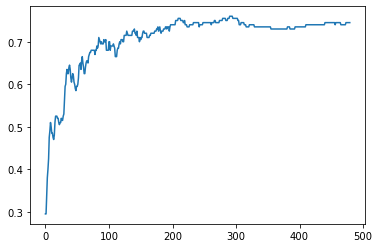

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data

clf = SGDClassifier(alpha=.0001, loss='log', penalty='l2', n_jobs=-1, shuffle=True, max_iter=100, verbose=0, tol=0.001)
 
accuracy = []
ROUNDS = 6
for _ in range(ROUNDS):
    batcherator = batch(X_train, y_train, 10)
    for index, (chunk_X, chunk_y) in enumerate(batcherator):
        clf.partial_fit(chunk_X, chunk_y, classes=[0, 1, 2])
 
        y_predicted = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_predicted))
plt.plot(accuracy)